06.Differential pathway abundance
========================================
 The analysis process includes three main steps, namely normalization, dispersion estimation and test for differential expression.  
   
   
PICRUSt2 (Phylogenetic Investigation of Communities by Reconstruction of Unobserved States) is a software for predicting functional abundances based only on marker gene sequences. Check out the pre-print here https://www.biorxiv.org/content/10.1101/672295v1.

"Function" usually refers to gene families such as KEGG orthologs and Enzyme Classification numbers, but predictions can be made for any arbitrary trait. Similarly, predictions are typically based on 16S rRNA gene sequencing data, but other marker genes can also be used. Enzyme classification can be summarized into pathway abundances using a pathway database. In this work we use the MetaCyc Metabolic Pathway Database https://metacyc.org/ .


In [34]:
library(phyloseq)
library(ggplot2)
library(scales)
library(gridExtra)
suppressPackageStartupMessages(library(edgeR))
library(matrixStats)

In [35]:
abundance <- read.table(snakemake@input$abundance, sep="\t", row.names=1, skip=1, comment.char="?", header=TRUE, check.names=FALSE)
abundance <- abundance
df <- read.table(snakemake@input$sample_info, sep="\t", row.names=1, header=TRUE)
df <- df[colnames(abundance),]

In [36]:
group <- factor(df[,snakemake@params$condition])
cat("Condition: ", snakemake@params$condition, "\n")
cat("Summary:\n")
print(summary(group))
if (!is.null(snakemake@params$ref_level)){
    cat("Setting", snakemake@params$ref_level, "as reference level", "\n")
    group <- relevel(group, ref = snakemake@params$ref_level) 
}
df[,"Sample_Group"] <- df[,snakemake@params$condition] <- group


batch <- NULL
if (!is.null(snakemake@params$batch)){
    print(cat("\nBatch factor given as: ", snakemake@params$batch, "\n"))
    batch <- factor(snakemake@params$batch)
    print(summary(batch))
    df[,snakemake@params$batch] <- batch
}

batch <- NULL
if (!is.null(snakemake@params$batch)){
    print(cat("\nBatch factor given as: ", snakemake@params$batch, "\n"))
    batch <- factor(snakemake@params$batch)
    print(summary(batch))
    df[,snakemake@params$batch] <- batch
}


Condition:  Dive_Name 
Summary:
     ctrl   T0   T1   T2 
   1   23   23   23   23 
Setting ctrl as reference level 


In [37]:
MODEL = snakemake@config$models[[snakemake@wildcards$model]]

In [38]:
subset.ids <- function(X, df, params){
    # set defaults if missing params
    if (!"axis" %in% names(params)) params$axis <- "column"
    if (!"name" %in% names(params)) params$name <- "Subset"
    if (!params$name %in% colnames(df)) stop("params.name not in df")
    if (!"selection" %in% names(params)) params$selection <- "keep"
    if ("ids" %in% names(params)){
        keep <- colnames(X) %in% params$ids
        if (sum(keep) == 0) stop("no overlap in subset ids from model.yaml")
    } else{
        if (!params$name %in% colnames(df)){
            stop(cat("missing column:", params$name, "in metadata."))
        } 
        subset_col <- as.character(df[,params$name])
        keep <- subset_col == as.character(params$selection)
        if (sum(keep) == 0) stop(paste0("no overlap in selection ", params$selection, ": ", params$name))
    }
    if (params$axis == "column"){
        X <- X[,keep]
    } else{
        X <- X[keep,]
    }
}

In [39]:
if (!is.null(MODEL$subsets)){
    for (p in MODEL$subsets){
        abundance <- subset.ids(abundance, df, p)
        df <- droplevels(df[colnames(abundance),])
    }
}


Note that this file is not in units of relative abundance (e.g. percent) and is instead the sum of the predicted functional abundance contributed by each ASV multiplied by the abundance (the number of input reads) of each ASV.

In [41]:
 if (utils::packageVersion("ggplot2") >= "3.3.0") expand_scale <- expansion
barplotTotal <- function(counts, group, col=c("lightblue","orange","MediumVioletRed","SpringGreen"), outfile=TRUE){
  if (outfile) png(filename="figures/barplotTotal.png", width=min(3600, 1800+800*ncol(counts)/10), height=1800, res=300)
  d <- data.frame(tc=colSums(counts)/1e6, sample=factor(colnames(counts), colnames(counts)), group)
  print(ggplot(d, aes(x=.data$sample, y=.data$tc, fill=.data$group)) +
          geom_bar(stat="identity", show.legend=TRUE) +
          labs(fill="") +
          scale_fill_manual(values=col) +
          xlab("Samples") + 
          ylab("Total pathway abundance (million)") +
          scale_y_continuous(expand=expand_scale(mult=c(0.01, 0.05))) +
          ggtitle("Total read abundance per sample (million)") +
          theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)))
  if (outfile) dev.off()
}

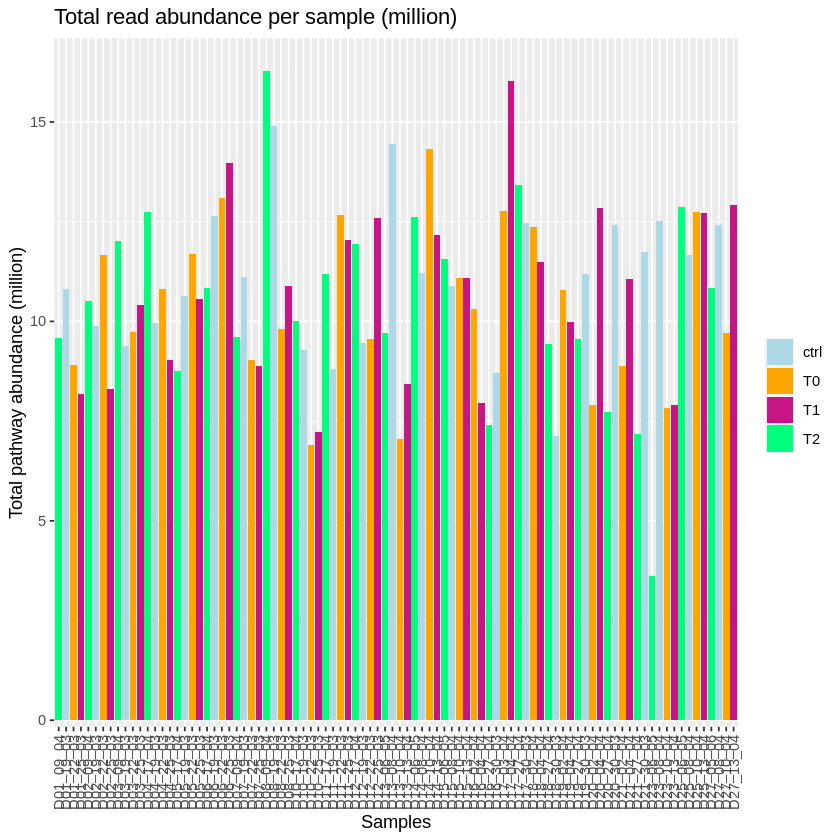

In [42]:
barplotTotal(abundance, df$Sample_Group, outfile=FALSE)

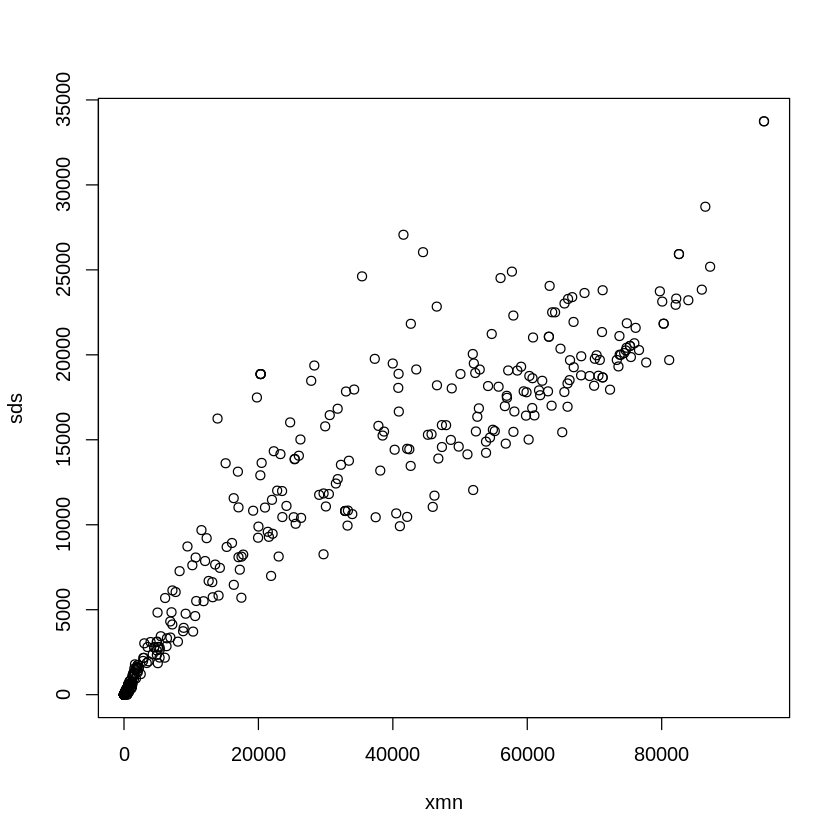

In [43]:
sds <- rowIQRs(as.matrix(abundance))
xmn <- rowMeans(abundance)
plot(xmn, sds)

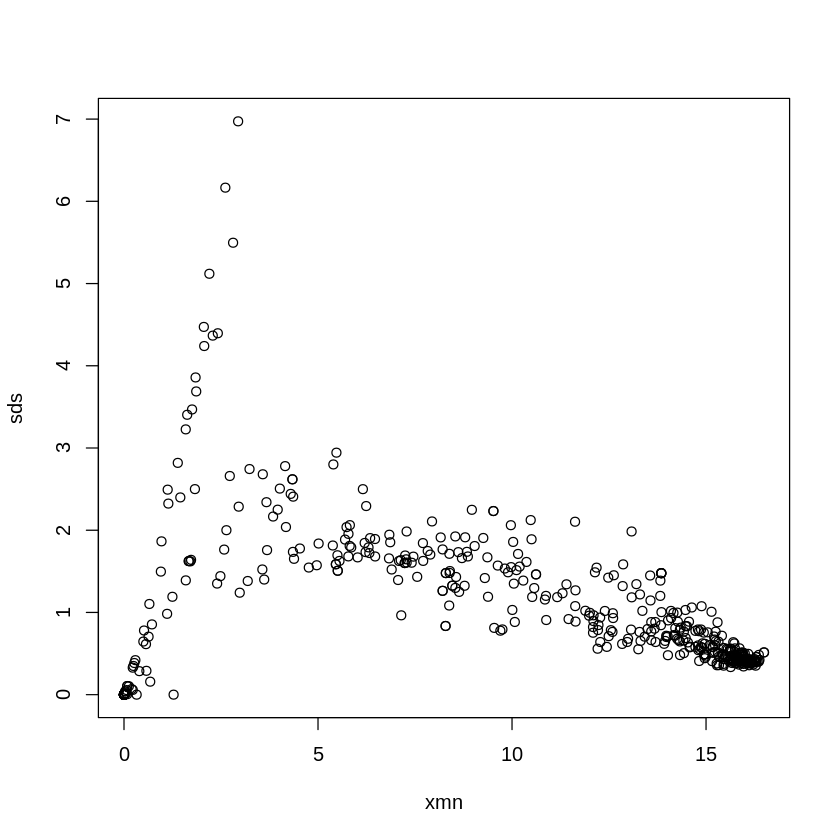

In [44]:
sds <- rowIQRs(as.matrix(log2(abundance+1)))
xmn <- rowMeans(log2(abundance+1))
plot(xmn, sds)

In [45]:
countsBoxplots <- function(object, group, col = c("lightblue","orange","MediumVioletRed","SpringGreen"), outfile=TRUE){
  if (class(object)=="DESeqDataSet"){
    counts <- counts(object)
    #counts <- removeNull(counts)
    norm.counts <- counts(object, normalized=TRUE)
    #norm.counts <- removeNull(norm.counts)  
  } else{
    counts <- object$counts
    #counts <- removeNull(counts)
    tmm <- object$samples$norm.factors
    N <- colSums(object$counts)
    f <- tmm * N/mean(tmm * N)
    norm.counts <- scale(object$counts, center=FALSE, scale=f)
    #norm.counts <- removeNull(norm.counts)    
  }

  if (outfile) png(filename="figures/countsBoxplots.png", width=2*min(2200, 1800+800*ncol(norm.counts)/10), height=1800, res=300)
  d <- stack(as.data.frame(counts))
  d$group <- rep(group, each=nrow(counts))
  p1 <- ggplot(d) + 
    geom_boxplot(aes(x=.data$ind, y=.data$values+1, fill=.data$group), show.legend=TRUE) +
    labs(fill="") +
    scale_y_continuous(trans = log10_trans(),
                       breaks = trans_breaks("log10", function(x) 10^x),
                       labels = trans_format("log10", math_format(~10^.x))) +
    scale_fill_manual(values=col) +
    xlab("Samples") +
    ylab("Raw counts") +
    ggtitle("Raw counts distribution") +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))
  
  d <- stack(as.data.frame(norm.counts))
  d$group <- rep(group, each=nrow(norm.counts))
  p2 <- ggplot(d) + 
    geom_boxplot(aes(x=.data$ind, y=.data$values+1, fill=.data$group), show.legend=TRUE) +
    labs(fill="") +
    scale_y_continuous(trans = log10_trans(),
                       breaks = trans_breaks("log10", function(x) 10^x),
                       labels = trans_format("log10", math_format(~10^.x))) +
    scale_fill_manual(values=col) +
    xlab("Samples") +
    ylab("Normalized counts") +
    ggtitle("Normalized counts distribution") +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))
  
  grid.arrange(p1, p2, nrow=2, ncol=1)
  if (outfile) dev.off()
    
}

In [46]:
#countsBoxplots(de, df$Sample_Group, outfile=FALSE)

In [47]:
densityPlot <- function(counts, group, col=c("lightblue","orange","MediumVioletRed","SpringGreen"), outfile=TRUE){
  if (outfile) png(filename="figures/densplot.png", width=2000, height=1800, res=300)
    #counts <- removeNull(counts)
    d <- stack(data.frame(counts))
    d$group <- rep(group, each=nrow(counts))
    print(ggplot(d, aes(x=.data$values+1)) +
            stat_density(aes(group=.data$ind, color=.data$group), position="identity", geom="line", show.legend=TRUE) +
            scale_x_continuous(trans = log10_trans(),
                               breaks = trans_breaks("log10", function(x) 10^x),
                               labels = trans_format("log10", math_format(~10^.x))) +
            labs(color="") +
            scale_colour_manual(values=col) +
            xlab("Raw counts") +
            ylab("Density") +
            ggtitle("Density of counts distribution"))
  if (outfile) dev.off()
}

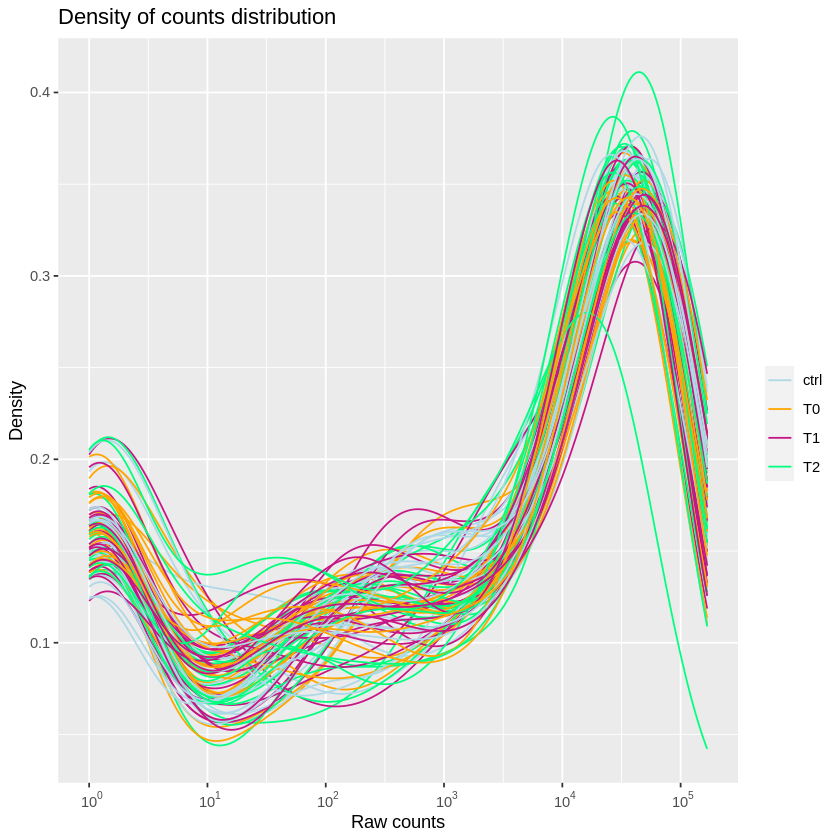

In [48]:
densityPlot(abundance, df$Sample_Group, outfile=FALSE)

In [49]:
majSequences <- function(rds, n=3, group, col=c("lightblue","orange","MediumVioletRed","SpringGreen"), outfile=TRUE){
  counts <- as(rds, "matrix")
  
  seqnames <- apply(counts, 2, function(x){x <- sort(x, decreasing=TRUE); names(x)[1:n]})
  seqnames <- unique(unlist(as.character(seqnames)))

  sum <- apply(counts,2,sum)
  counts <- counts[seqnames,]
  sum <- matrix(sum,nrow(counts),ncol(counts),byrow=TRUE)
  p <- round(100*counts/sum,digits=3)

  if (outfile) png(filename="figures/majSeq.png",width=min(3600,1800+800*ncol(counts)/10),height=1800,res=300)
    maj <- apply(p, 2, max)
    seqname <- rownames(p)[apply(p, 2, which.max)]
    #TAX <- data.frame(as(tax_table(rds), "matrix"))[seqname,]
    #taxname <- as.character(TAX[,taxrank])
    #taxname[is.na(taxname)] <- as.character(TAX[is.na(taxname),"Genus"])
    d <- data.frame(maj=maj, sample=factor(names(maj), levels=names(maj)), group, seqname=seqname)
    print(ggplot(d, aes(x=.data$sample, y=.data$maj, fill=.data$group)) +
            geom_bar(stat="identity", show.legend=TRUE) +
            labs(fill="") +
            scale_fill_manual(values=col) +
            xlab("Samples") + 
            ylab("Percentage of reads") +
            scale_y_continuous(expand=expand_scale(mult=c(0.01, 0.05))) +
            ggtitle("Percentage of reads from most expressed pathway") +
            theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)) +
            geom_text(aes(y=0.8*maj, label=seqname), color="black", size=2.5, angle=90, fontface="bold"))
  if (outfile) dev.off()
  
  return(invisible(p))
}

In [52]:
#majSequences(abundance, n=3, df$Sample_Group, outfile=FALSE)

----------------------

In [51]:
if (!is.null(snakemake@params$block)){
    f <- as.formula(paste0("~", snakemake@params$block, "+", snakemake@params$condition))
    } else {
    f <- as.formula(paste0("~", snakemake@params$condition))
    }

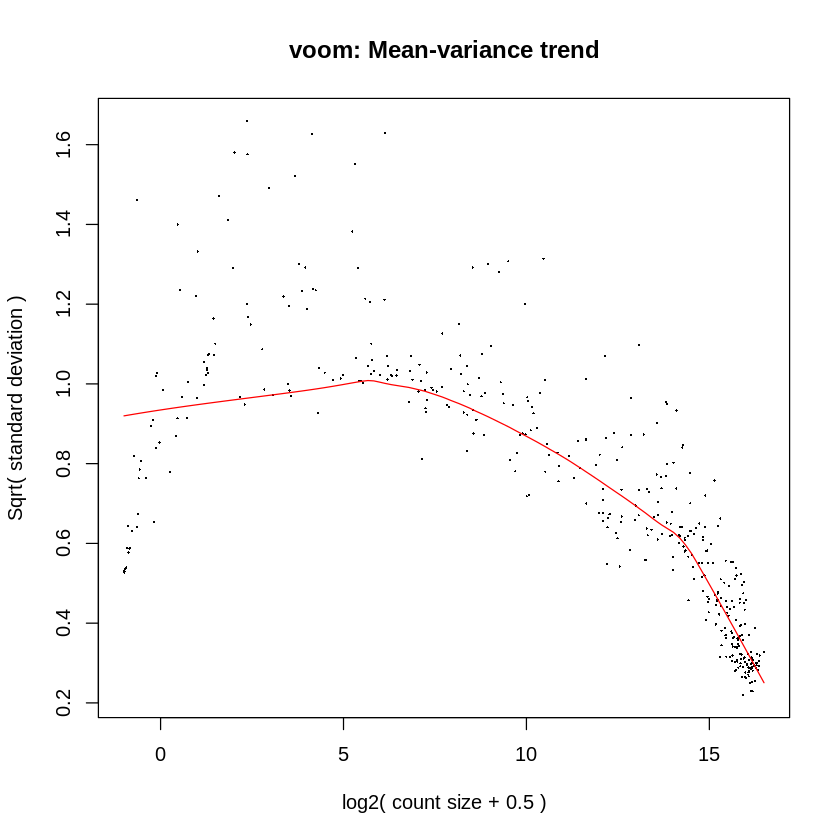

In [53]:
des <- model.matrix(f, data=df)
#colnames(des) <- levels(df$Sample_Group)
#colnames(des) <- c('HC','PPI','PPI.FGP')
v <- voom(abundance, design=des, plot=TRUE)

In [54]:
fit <- lmFit(v, design=des)

In [55]:
#cmat <- makeContrasts("PPI__vs__HC" = PPI-HC, "PPI__vs__FGP"=PPI_FGP - HC, "PPI__vs__PPI_FGP"= PPI-PPI_FGP, levels=des)

In [56]:
#fit <- contrasts.fit(fit0, cmat)

In [57]:
fit2 <- eBayes(fit)

In [69]:
complete <- list()
coef.names <- colnames(coef(fit2))
n.coef <- length(coef.names)
n.cond <- nlevels(df[,snakemake@params$condition]) - 2
CONTRASTS <- coef.names[(n.coef-n.cond):n.coef]
library(stringr)
urls <- paste0("https://biocyc.org/META/NEW-IMAGE?type=PATHWAY&object=", rownames(fit2))
pth.info <- data.frame(URL=urls)
rownames(pth.info) <- rownames(fit2)
for (contrast in CONTRASTS){
    tab <- topTable(fit2, coef=contrast, genelist=pth.info, sort.by="P")
    fn <- file.path(snakemake@output[[1]], paste0("voom", "_", contrast, ".txt"))
    dir.create(snakemake@output[[1]], showWarnings=FALSE, recursive=TRUE)
    write.table(tab, file=fn, sep="\t")
    complete[[contrast]] <- tab
}

In [63]:
nDiffTotal <- function(complete, alpha=0.05){
  nDiffTotal <- matrix(NA,ncol=4,nrow=length(complete),dimnames=list(names(complete),c("Test vs Ref", "# down","# up","# total")))
  for (name in names(complete)){
    complete.name <- complete[[name]]
    if (!is.null(complete.name$padj)) complete.name$padj <- complete.name[,"adj.P.Val"]
    if (!is.null(complete.name$log2FoldChange)) complete.name$log2FoldChange <- complete.name[,"logFC"]
    if (!is.null(complete.name$betaConv)){
    nDiffTotal[name,2:3]=c(nrow(complete.name[which(complete.name$padj <= alpha & complete.name$betaConv & complete.name$log2FoldChange<=0),]),
                             nrow(complete.name[which(complete.name$padj <= alpha & complete.name$betaConv & complete.name$log2FoldChange>=0),]))
    } else{
        head(complete.name)
      nDiffTotal[name,2:3]=c(nrow(complete.name[which(complete.name$padj <= alpha & complete.name$log2FoldChange<=0),]),
                             nrow(complete.name[which(complete.name$padj <= alpha & complete.name$log2FoldChange>=0),]))
    }
      complete[[name]] <- complete.name
  }
  nDiffTotal[,4] <- nDiffTotal[,2] + nDiffTotal[,3]
  nDiffTotal[,1] <- gsub("_"," ",rownames(nDiffTotal))
  rownames(nDiffTotal) <- NULL
  return(nDiffTotal)
}

In [64]:
nDiffTotal(complete)

Test vs Ref,# down,# up,# total
Dive NameT0,0,0,0
Dive NameT1,0,0,0
Dive NameT2,0,0,0


In [65]:
volcanoPlot <- function(complete, alpha=0.05, outfile=TRUE, padjlim=NULL){
  ncol <- min(2, length(complete))
  nrow <- ceiling(length(complete)/ncol)
  if (outfile) png(filename="figures/volcanoPlot.png", width=cairoSizeWrapper(1800*ncol), height=cairoSizeWrapper(1800*nrow), res=300)
  p <- list()
  for (name in names(complete)){
    complete.name <- complete[[name]]
    if (!is.null(complete.name$padj)) complete.name$padj <- complete.name[,"adj.P.Val"]
    if (!is.null(complete.name$log2FoldChange)) complete.name$log2FoldChange <- complete.name[,"logFC"]
    complete.name$padj[which(complete.name$padj==0)] <- .Machine$double.xmin
    complete.name <- complete.name[which(!is.na(complete.name$padj)),]
    complete.name$DE <- factor(ifelse(complete.name$padj <= alpha, "yes", "no"), levels=c("no", "yes"))
    if (is.null(padjlim)) padjlim.name <- quantile(complete.name$padj, probs=0.01, na.rm=TRUE) else padjlim.name <- padjlim
    complete.name$outfield <- factor(ifelse(complete.name$padj < padjlim.name, "top", "in"), levels=c("in", "top"))
    complete.name$padj[which(complete.name$padj < padjlim.name)] <- padjlim.name
    reverselog_trans <- function(base = exp(1)) {
      trans <- function(x) -log(x, base)
      inv <- function(x) base^(-x)
      trans_new(paste0("reverselog-", format(base)), trans, inv,
                log_breaks(base = base),
                domain = c(.Machine$double.xmin, Inf))
    }
    p[[name]] <- ggplot(data=complete.name, 
                        aes(x=.data$log2FoldChange, y=.data$padj, color=.data$DE, shape=.data$outfield)) +
      geom_point(show.legend=FALSE, alpha=0.5) +
      scale_y_continuous(trans = reverselog_trans(10),
                         breaks = trans_breaks("log10", function(x) 10^x),
                         labels = trans_format("log10", math_format(~10^.x))) +
      scale_colour_manual(values=c("no"="black", "yes"="red"), drop=FALSE) +
      scale_shape_manual(values=c("in"=16, "top"=17), drop=FALSE) +
      xlab(expression(log[2]~fold~change)) +
      ylab("Adjusted P-value") +
      ggtitle(paste0("Volcano plot - ", gsub("_", " ", name)))
  }
  tmpfun <- function(...) grid.arrange(..., nrow=nrow, ncol=ncol)
  do.call(tmpfun, p)
  if (outfile) dev.off()
}
                         

In [66]:
#volcanoPlot(complete, outfile=FALSE)

In [67]:
MAPlot <- function(complete, alpha=0.05, outfile=TRUE, log2FClim=NULL){
  ncol <- min(2, length(complete))
  nrow <- ceiling(length(complete)/ncol)
  if (outfile) png(filename="figures/MAPlot.png", width=cairoSizeWrapper(1800*ncol), height=cairoSizeWrapper(1800*nrow), res=300)
  p <- list()
  for (name in names(complete)){
    complete.name <- complete[[name]]
    if (!is.null(complete.name$padj)) complete.name$padj <- complete.name[,"adj.P.Val"]
    if (!is.null(complete.name$log2FoldChange)) complete.name$log2FoldChange <- complete.name[,"logFC"]
        if (!is.null(complete.name$baseMean)) complete.name$baseMean <- complete.name[,"AveExpr"]
    if (!is.null(complete.name$log2FoldChange)) complete.name$log2FoldChange <- complete.name[,"logFC"]
    complete.name <- complete.name[which(complete.name$baseMean>0),]
    complete.name$padj <- ifelse(is.na(complete.name$padj), 1, complete.name$padj)
    complete.name$DE <- factor(ifelse(complete.name$padj <= alpha, "yes", "no"), levels=c("no", "yes"))
    py <- complete.name$log2FoldChange
    if (is.null(log2FClim)) ymax <- quantile(abs(py[is.finite(py)]), probs=0.99) else ymax <- log2FClim
    complete.name$log2FoldChange[which(py > ymax)] <- ymax
    complete.name$log2FoldChange[which(py < -ymax)] <- -ymax
    complete.name$outfield <- factor(ifelse(py > ymax, "top", ifelse(py < -ymax, "bottom", "in")), 
                                     levels=c("bottom", "in", "top"))
    p[[name]] <- ggplot(data=complete.name, 
                        aes(x=.data$baseMean, y=.data$log2FoldChange, color=.data$DE, fill=.data$DE, shape=.data$outfield)) +
      scale_x_continuous(trans = log10_trans(),
                         breaks = trans_breaks("log10", function(x) 10^x),
                         labels = trans_format("log10", math_format(~10^.x))) +
      geom_point(show.legend=FALSE, alpha=0.5, size=0.8) +
      scale_colour_manual(values=c("no"="black", "yes"="red"), drop=FALSE) +
      scale_shape_manual(values=c("bottom"=25, "in"=21, "top"=24), drop=FALSE) +
      scale_fill_manual(values=c("no"="black", "yes"="red"), drop=FALSE) +
      scale_y_continuous(expand=expand_scale(mult=c(0.03, 0.03))) +
      xlab("Mean of normalized counts") +
      ylab(expression(log[2]~fold~change)) +
      ggtitle(paste0("MA-plot - ", gsub("_"," ",name)))
  }
  tmpfun <- function(...) grid.arrange(..., nrow=nrow, ncol=ncol)
  do.call(tmpfun, p)
  if (outfile) dev.off()
}

In [68]:
#MAPlot(complete, outfile=FALSE)

ERROR: Error in abs(py[is.finite(py)]): non-numeric argument to mathematical function
